In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("final_dataset.csv")

In [3]:
df.shape

(5604, 3554)

In [4]:
# Separate features and target
X = df.drop(columns=["max_delta_volume"])
y = df["max_delta_volume"]

In [5]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Scale features (important for XGBoost performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Original

In [7]:
xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)


In [8]:
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Predictions
y_pred = xgb_model.predict(X_test_scaled)

In [10]:
# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [11]:
mse, r2

(9.827414605775735, 0.7770302409744967)

# **Grid search**

In [12]:
# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

In [13]:
# Initialize model
xgb = XGBRegressor(random_state=42)

In [14]:
# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [15]:
# Fit the model (use scaled training data)
grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [4, 6, 8], 'n_estimators': [50, 100],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [16]:
# Output best params and score
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best R² Score: 0.6037297980970343


In [17]:
best_model = grid_search.best_estimator_

In [18]:
y_pred = best_model.predict(X_test_scaled)

In [19]:
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.9264847147556665
Test MSE: 3.2401936079380906


# SHAP for XGBoost Regression Model - Global

In [20]:
# Initialize SHAP TreeExplainer with the best XGBoost model
explainer = shap.Explainer(best_model)

In [21]:
# Compute SHAP values on the test set
shap_values = explainer(X_test_scaled)

In [22]:
# Attach feature names (optional but helpful)
shap_values.feature_names = X.columns.tolist()

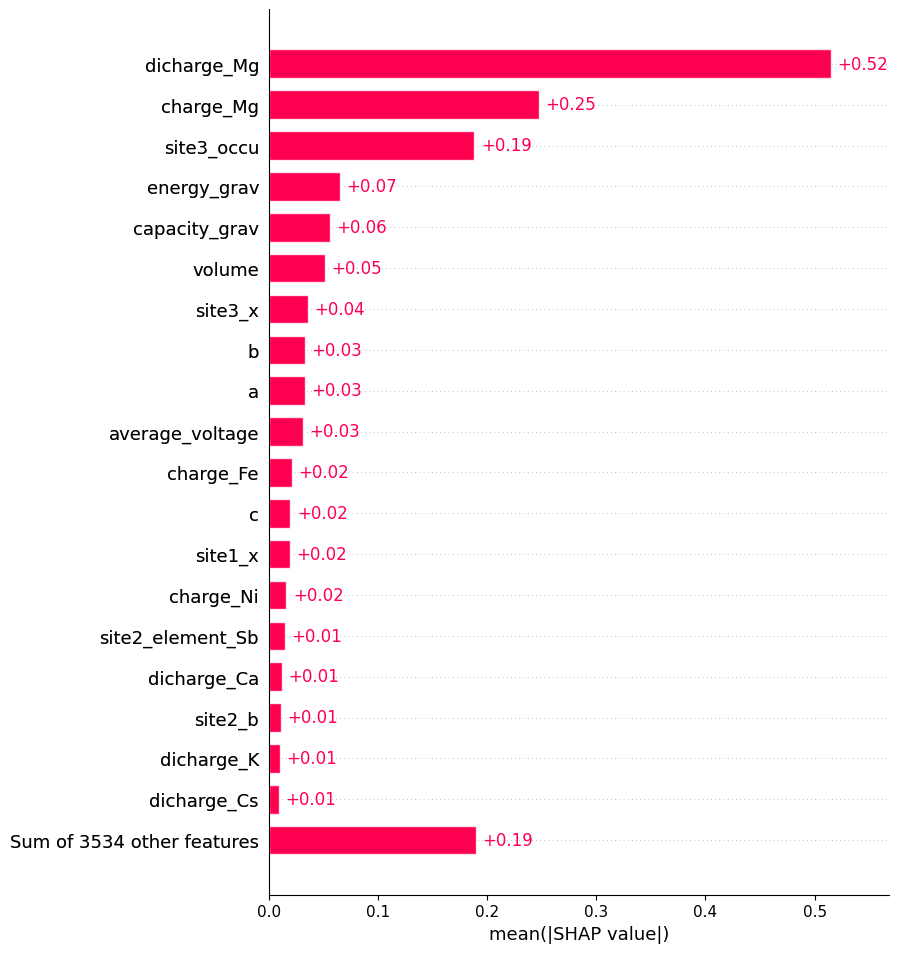

In [23]:

# Plot SHAP bar chart: Mean absolute importance of each feature
shap.plots.bar(shap_values, max_display=20)

# SHAP Local Explanation for a Single Sample

In [41]:
# 1. Initialize SHAP explainer (TreeExplainer is optimal for XGBoost)
explainer = shap.Explainer(best_model)

In [42]:

# 2. Compute SHAP values for the entire test set (or just one instance)
shap_values = explainer(X_test_scaled)

In [43]:
shap_values.feature_names = X.columns.tolist()

In [44]:
# 3. Pick a single sample to explain (e.g., first one)
sample_index = 0  # change this to explore other samples

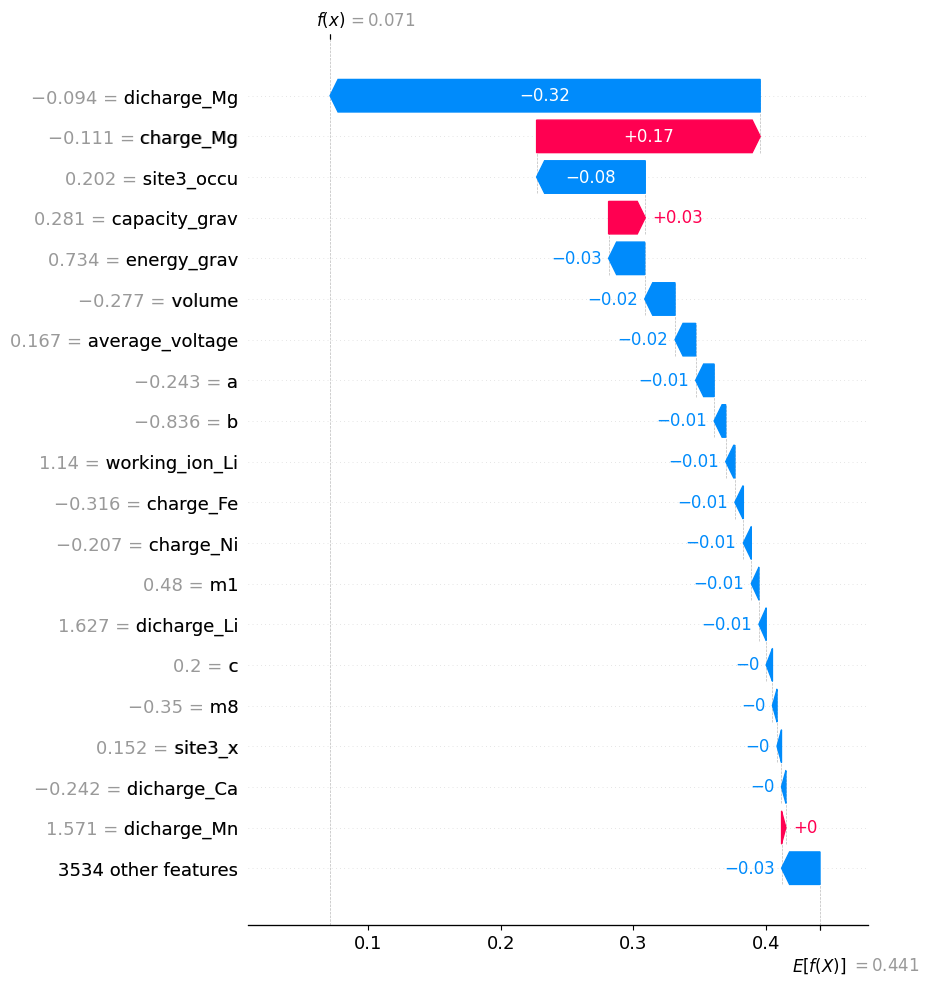

In [45]:
shap.plots.waterfall(shap_values[sample_index], max_display=20)

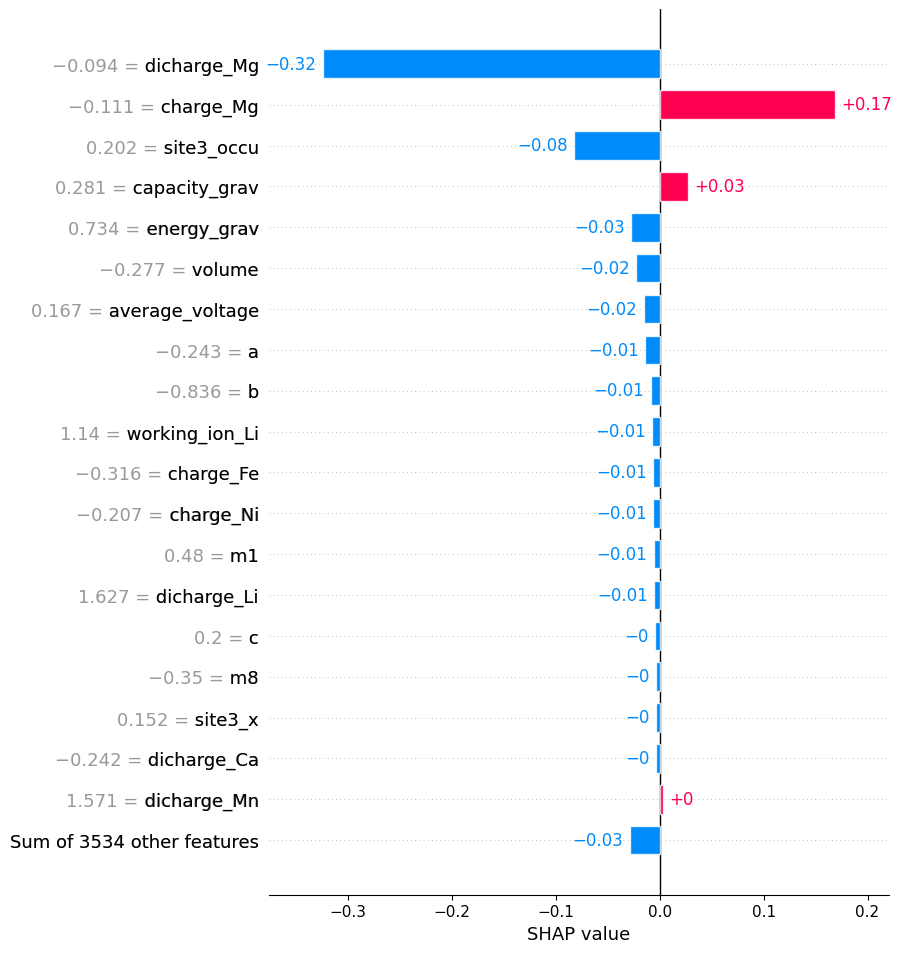

In [46]:
# Bar plot for local explanation (single instance)
shap.plots.bar(shap_values[sample_index], max_display=20)

In [47]:
# Optional: print prediction + true value
pred = best_model.predict(X_test_scaled[sample_index:sample_index+1])[0]
print(f"Prediction: {pred:.4f}, Actual: {y_test.iloc[sample_index]:.4f}")

Prediction: 0.0714, Actual: 0.1139


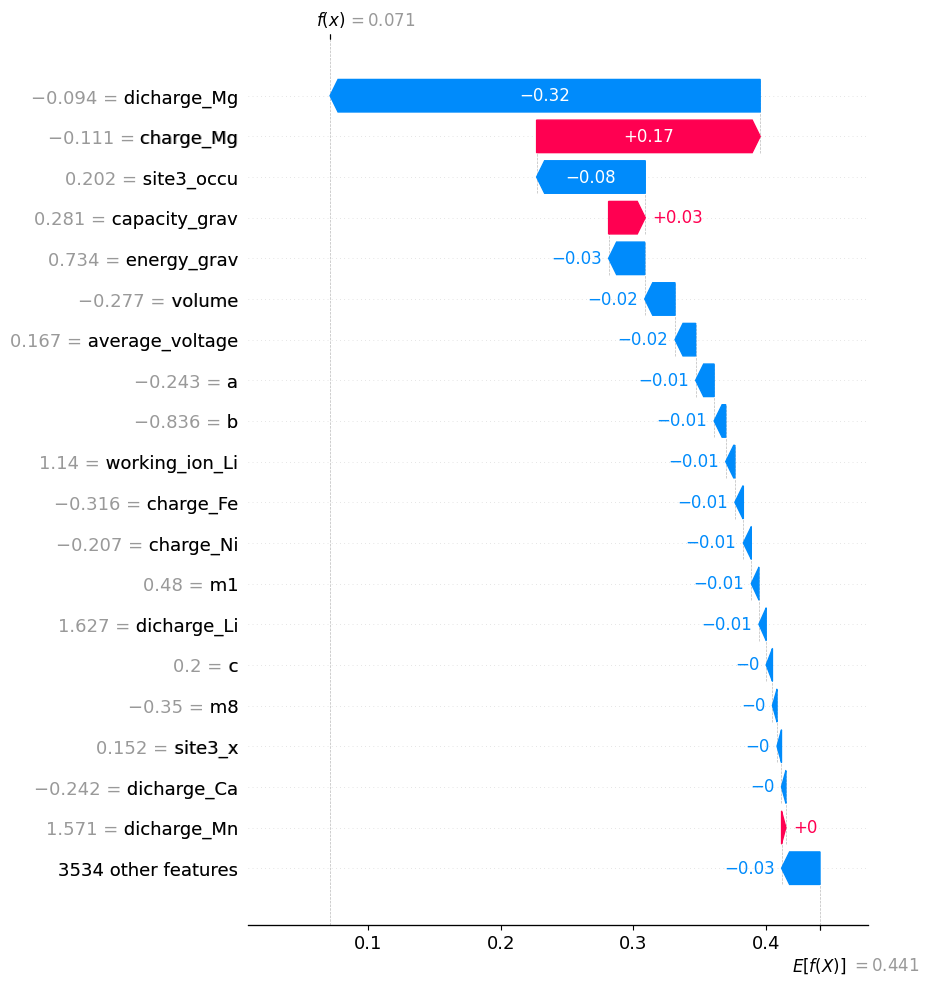

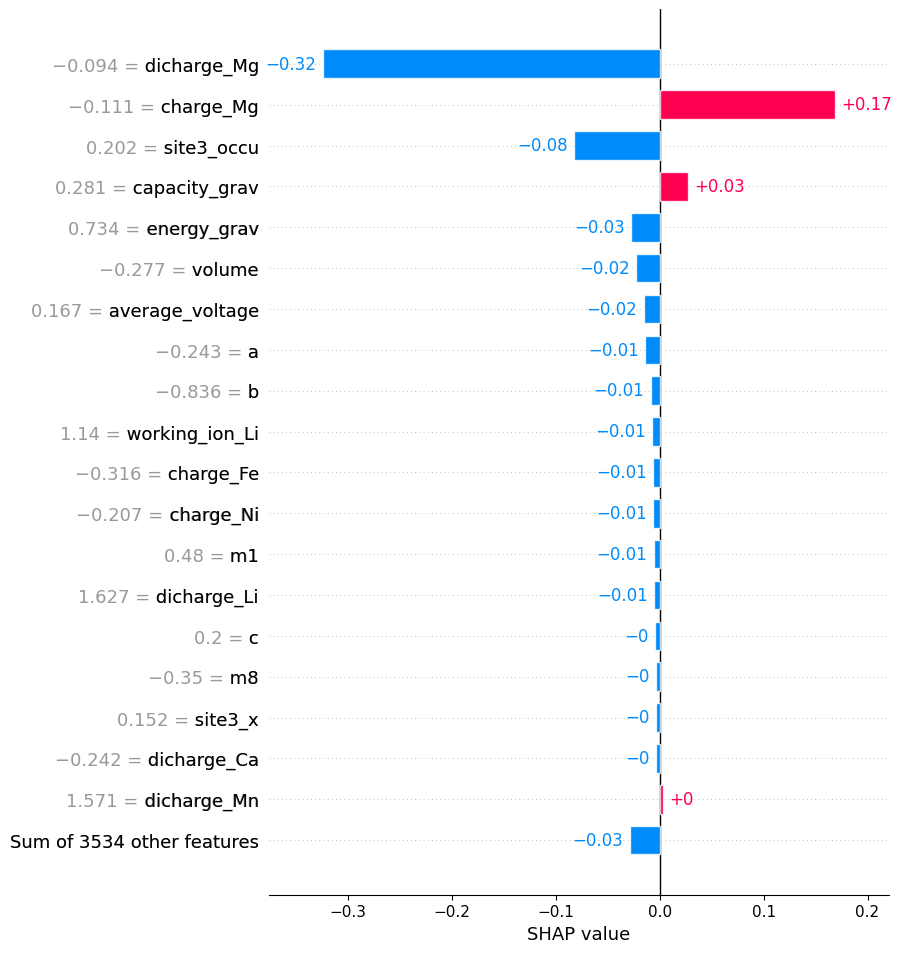

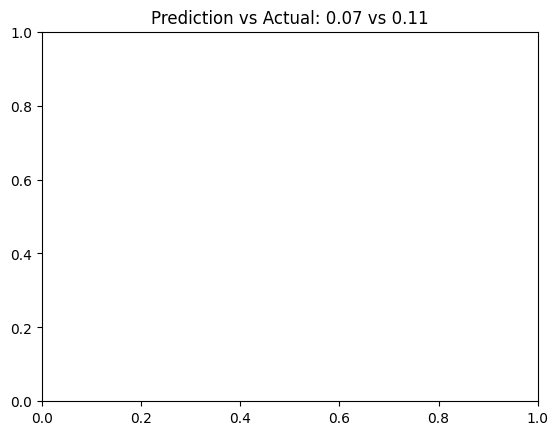

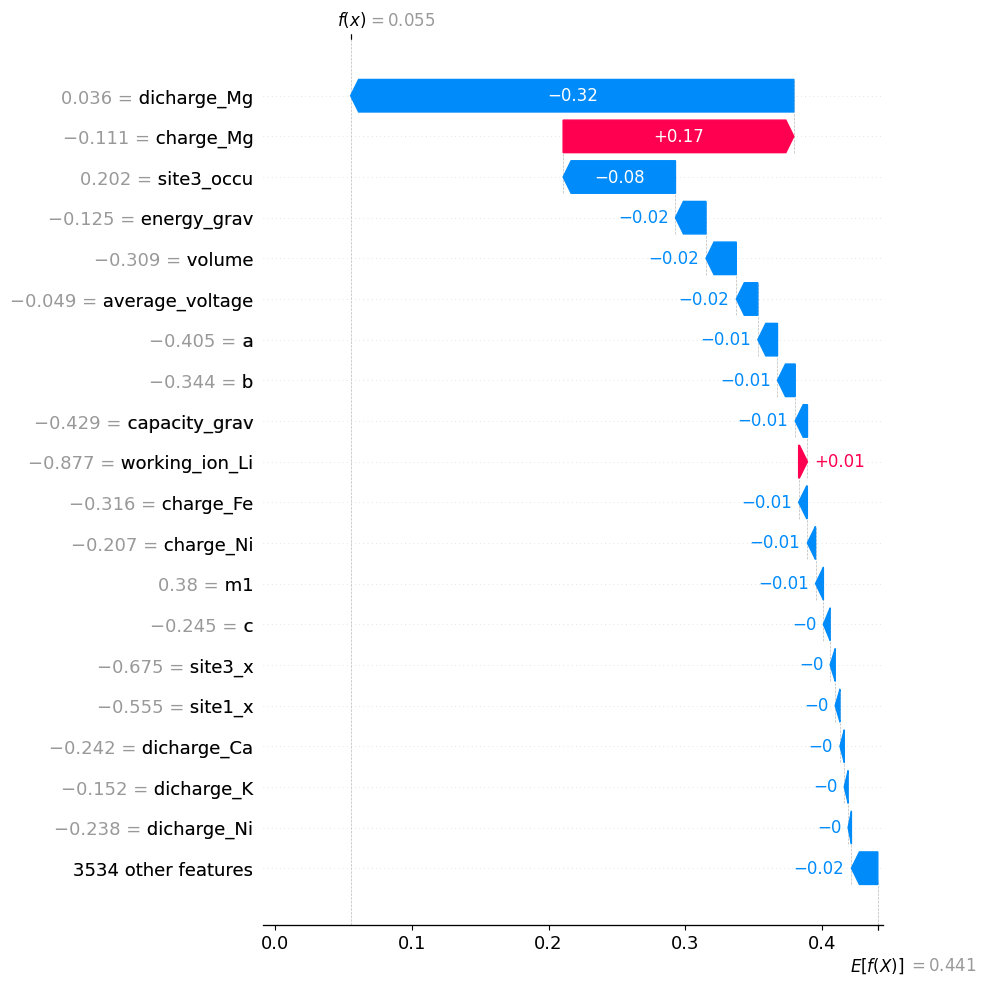

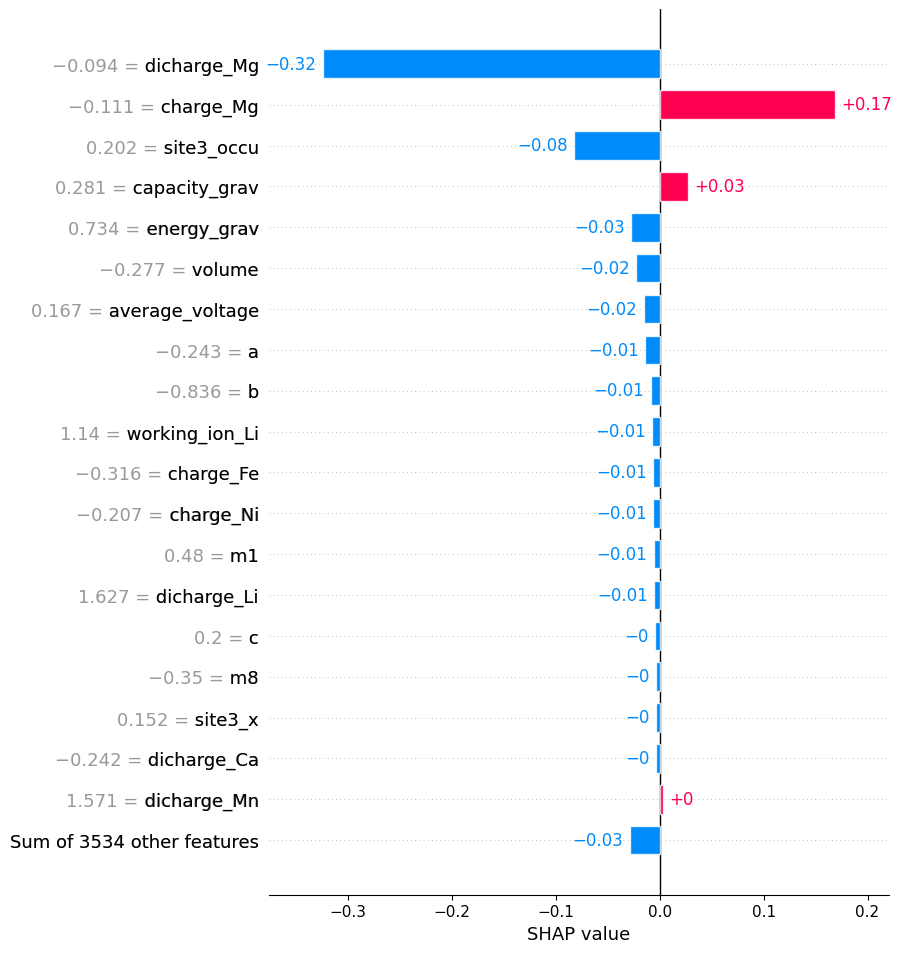

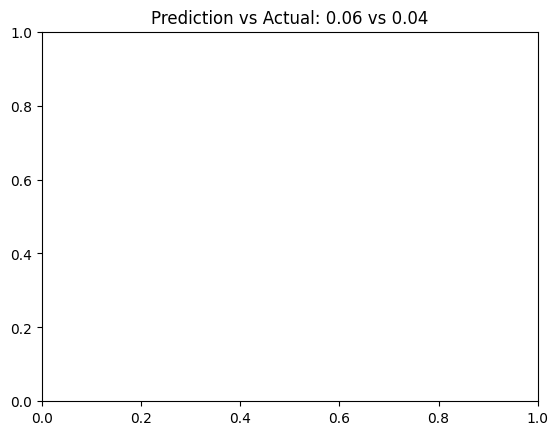

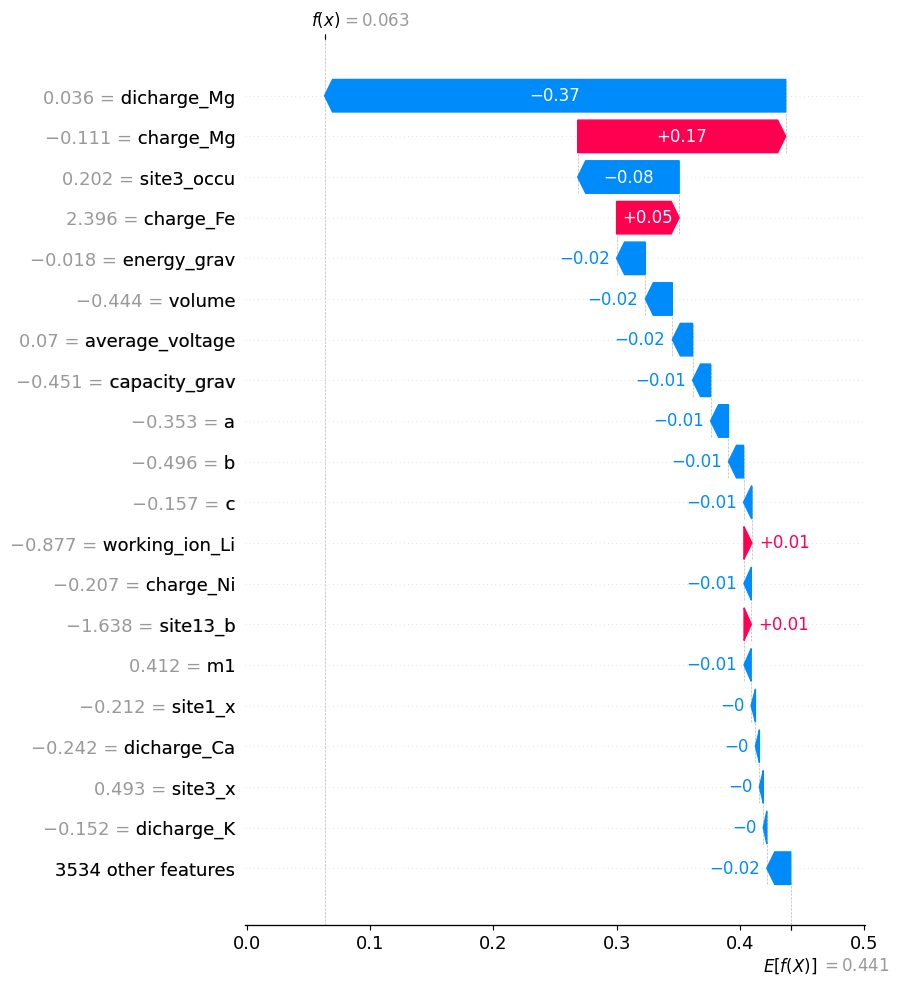

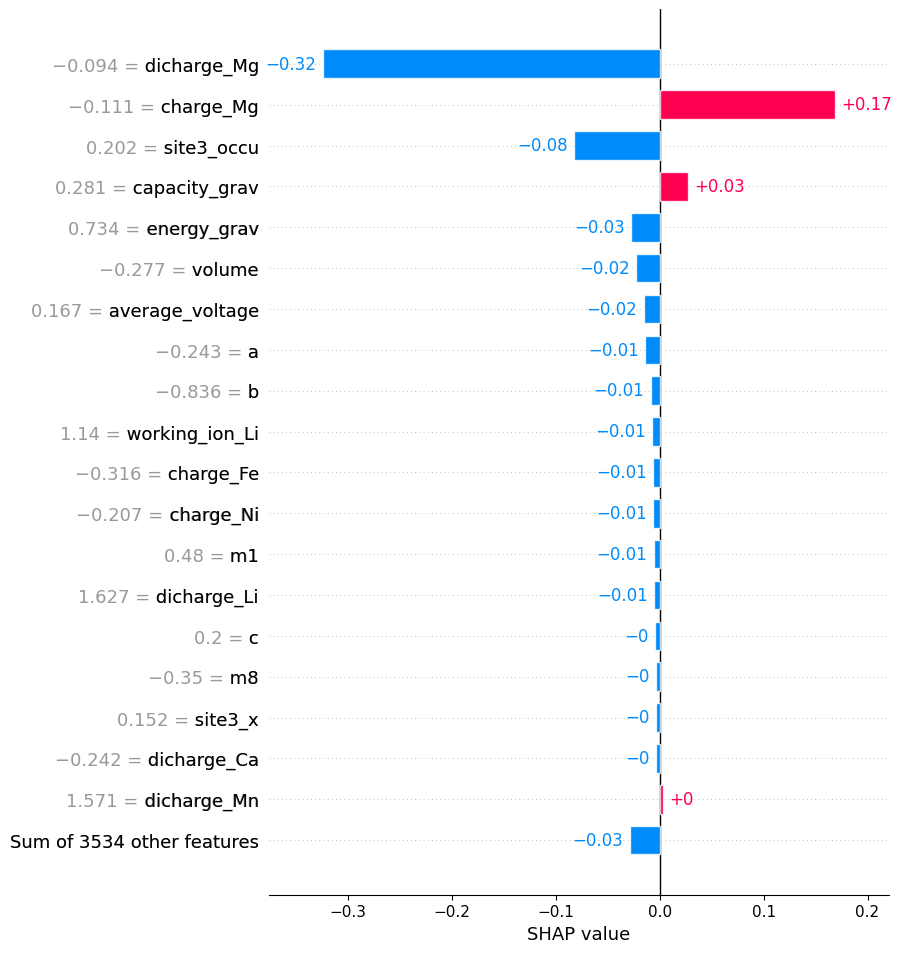

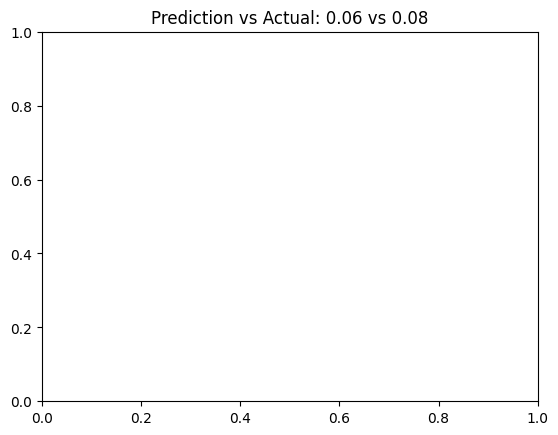

In [48]:
for i in range(3):  # first 3 samples
    shap.plots.waterfall(shap_values[i], max_display=20)
    shap.plots.bar(shap_values[sample_index], max_display=20)
    plt.title(f"Prediction vs Actual: {best_model.predict(X_test_scaled[i:i+1])[0]:.2f} vs {y_test.iloc[i]:.2f}")
    plt.show()

In [49]:
# Convert the first row of X_test to a Pandas Series with column names
sample_features = pd.Series(X_test.iloc[0], index=X.columns)

# Print all feature names and their values
print("🔍 Feature values for X_test[0]:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

🔍 Feature values for X_test[0]:
working_ion_Al: False
working_ion_Ca: False
working_ion_Cs: False
working_ion_K: False
working_ion_Li: True
working_ion_Mg: False
working_ion_Na: False
working_ion_Rb: False
working_ion_Y: False
working_ion_Zn: False
FA_A: 1
FA_B: 3
FA_C: 4
FA_D: 16
FA_E: 0
FA_F: 0
charge_Al: 0.0
charge_Cu: 1.0
charge_Mn: 3.0
charge_Mo: 0.0
charge_Re: 0.0
charge_V: 0.0
charge_Sb: 0.0
charge_Fe: 0.0
charge_W: 0.0
charge_Sn: 0.0
charge_Ti: 0.0
charge_Ag: 0.0
charge_Bi: 0.0
charge_Ce: 0.0
charge_Ca: 0.0
charge_C: 0.0
charge_Li: 0.0
charge_Cr: 0.0
charge_Nb: 0.0
charge_Cd: 0.0
charge_Ac: 0.0
charge_S: 0.0
charge_Se: 0.0
charge_Pt: 0.0
charge_Cs: 0.0
charge_Br: 0.0
charge_H: 0.0
charge_Te: 0.0
charge_Co: 0.0
charge_Na: 0.0
charge_Ni: 0.0
charge_K: 0.0
charge_Ge: 0.0
charge_U: 0.0
charge_Zn: 0.0
charge_Mg: 0.0
charge_Hg: 0.0
charge_Pm: 0.0
charge_N: 0.0
charge_Rb: 0.0
charge_Tl: 0.0
charge_Nd: 0.0
charge_Pb: 0.0
charge_Sm: 0.0
charge_Si: 0.0
charge_O: 16.0
charge_Ba: 0.0
charg

In [50]:
# Convert the first row of X_test to a Pandas Series with column names
sample_features = pd.Series(X_test.iloc[1], index=X.columns)

# Print all feature names and their values
print("🔍 Feature values for X_test[1]:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

🔍 Feature values for X_test[1]:
working_ion_Al: False
working_ion_Ca: False
working_ion_Cs: False
working_ion_K: False
working_ion_Li: False
working_ion_Mg: True
working_ion_Na: False
working_ion_Rb: False
working_ion_Y: False
working_ion_Zn: False
FA_A: 1
FA_B: 2
FA_C: 6
FA_D: 0
FA_E: 0
FA_F: 0
charge_Al: 0.0
charge_Cu: 0.0
charge_Mn: 0.0
charge_Mo: 0.0
charge_Re: 0.0
charge_V: 0.0
charge_Sb: 0.0
charge_Fe: 0.0
charge_W: 0.0
charge_Sn: 0.0
charge_Ti: 0.0
charge_Ag: 0.0
charge_Bi: 2.0
charge_Ce: 0.0
charge_Ca: 0.0
charge_C: 0.0
charge_Li: 0.0
charge_Cr: 0.0
charge_Nb: 0.0
charge_Cd: 0.0
charge_Ac: 0.0
charge_S: 0.0
charge_Se: 0.0
charge_Pt: 0.0
charge_Cs: 0.0
charge_Br: 0.0
charge_H: 0.0
charge_Te: 0.0
charge_Co: 0.0
charge_Na: 0.0
charge_Ni: 0.0
charge_K: 0.0
charge_Ge: 0.0
charge_U: 0.0
charge_Zn: 0.0
charge_Mg: 0.0
charge_Hg: 0.0
charge_Pm: 0.0
charge_N: 0.0
charge_Rb: 0.0
charge_Tl: 0.0
charge_Nd: 0.0
charge_Pb: 0.0
charge_Sm: 0.0
charge_Si: 0.0
charge_O: 6.0
charge_Ba: 0.0
charge_

In [51]:
# Convert the first row of X_test to a Pandas Series with column names
sample_features = pd.Series(X_test.iloc[2], index=X.columns)

# Print all feature names and their values
print("🔍 Feature values for X_test[2]:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

🔍 Feature values for X_test[2]:
working_ion_Al: False
working_ion_Ca: False
working_ion_Cs: False
working_ion_K: False
working_ion_Li: False
working_ion_Mg: True
working_ion_Na: False
working_ion_Rb: False
working_ion_Y: False
working_ion_Zn: False
FA_A: 3
FA_B: 5
FA_C: 16
FA_D: 0
FA_E: 0
FA_F: 0
charge_Al: 0.0
charge_Cu: 0.0
charge_Mn: 0.0
charge_Mo: 0.0
charge_Re: 0.0
charge_V: 0.0
charge_Sb: 0.0
charge_Fe: 3.0
charge_W: 0.0
charge_Sn: 0.0
charge_Ti: 0.0
charge_Ag: 0.0
charge_Bi: 0.0
charge_Ce: 0.0
charge_Ca: 0.0
charge_C: 0.0
charge_Li: 0.0
charge_Cr: 0.0
charge_Nb: 0.0
charge_Cd: 0.0
charge_Ac: 0.0
charge_S: 0.0
charge_Se: 0.0
charge_Pt: 0.0
charge_Cs: 0.0
charge_Br: 0.0
charge_H: 0.0
charge_Te: 0.0
charge_Co: 5.0
charge_Na: 0.0
charge_Ni: 0.0
charge_K: 0.0
charge_Ge: 0.0
charge_U: 0.0
charge_Zn: 0.0
charge_Mg: 0.0
charge_Hg: 0.0
charge_Pm: 0.0
charge_N: 0.0
charge_Rb: 0.0
charge_Tl: 0.0
charge_Nd: 0.0
charge_Pb: 0.0
charge_Sm: 0.0
charge_Si: 0.0
charge_O: 16.0
charge_Ba: 0.0
charg

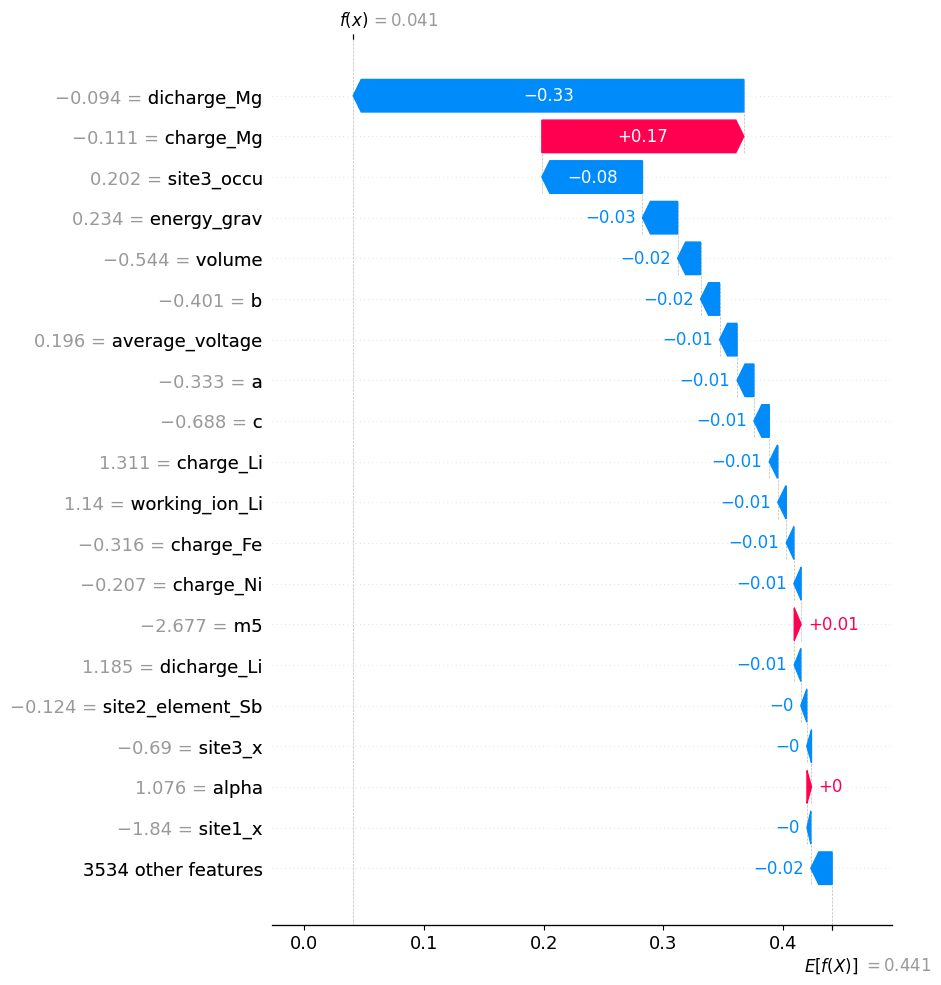

In [52]:
shap.plots.waterfall(shap_values[1000], max_display=20)

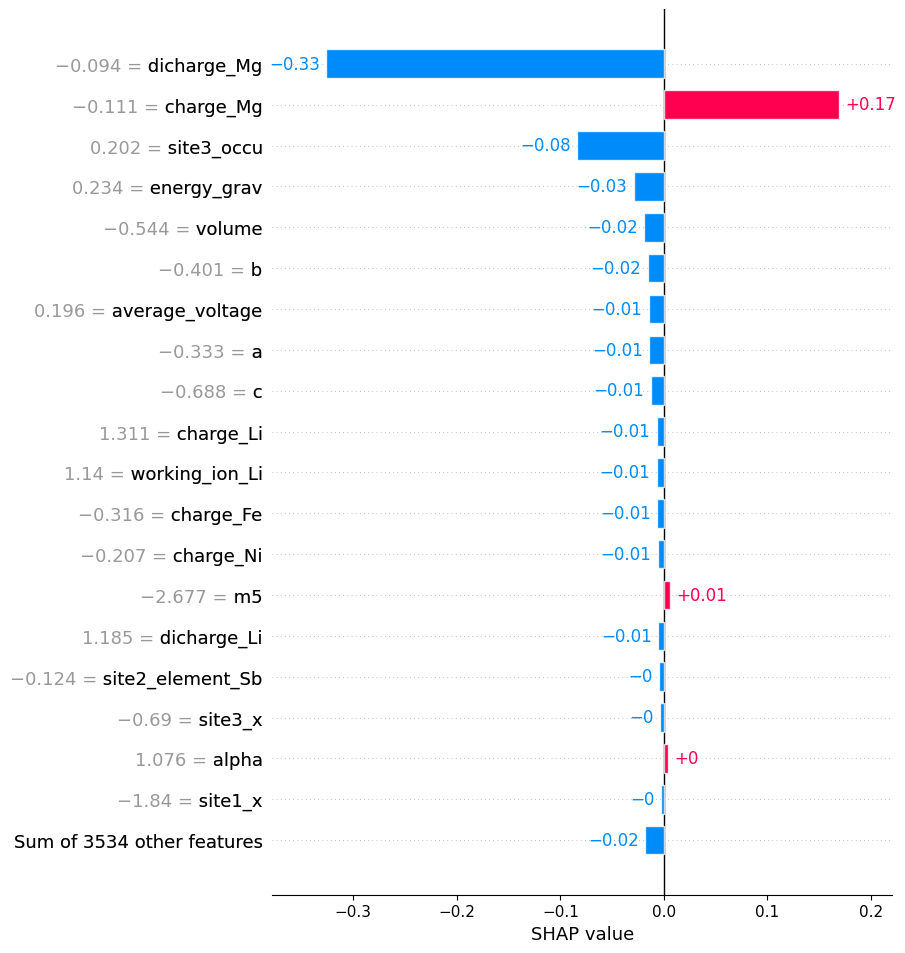

In [53]:
shap.plots.bar(shap_values[1000], max_display=20)

In [54]:
# Convert the first row of X_test to a Pandas Series with column names
sample_features = pd.Series(X_test.iloc[1000], index=X.columns)

# Print all feature names and their values
print("🔍 Feature values for X_test[1000]:")
for feature, value in sample_features.items():
    print(f"{feature}: {value}")

🔍 Feature values for X_test[1000]:
working_ion_Al: False
working_ion_Ca: False
working_ion_Cs: False
working_ion_K: False
working_ion_Li: True
working_ion_Mg: False
working_ion_Na: False
working_ion_Rb: False
working_ion_Y: False
working_ion_Zn: False
FA_A: 1
FA_B: 1
FA_C: 4
FA_D: 0
FA_E: 0
FA_F: 0
charge_Al: 0.0
charge_Cu: 0.0
charge_Mn: 0.0
charge_Mo: 0.0
charge_Re: 0.0
charge_V: 0.0
charge_Sb: 0.0
charge_Fe: 0.0
charge_W: 0.0
charge_Sn: 0.0
charge_Ti: 0.0
charge_Ag: 0.0
charge_Bi: 0.0
charge_Ce: 0.0
charge_Ca: 0.0
charge_C: 0.0
charge_Li: 2.0
charge_Cr: 3.0
charge_Nb: 0.0
charge_Cd: 0.0
charge_Ac: 0.0
charge_S: 0.0
charge_Se: 0.0
charge_Pt: 0.0
charge_Cs: 0.0
charge_Br: 0.0
charge_H: 0.0
charge_Te: 0.0
charge_Co: 3.0
charge_Na: 0.0
charge_Ni: 0.0
charge_K: 0.0
charge_Ge: 0.0
charge_U: 0.0
charge_Zn: 0.0
charge_Mg: 0.0
charge_Hg: 0.0
charge_Pm: 0.0
charge_N: 0.0
charge_Rb: 0.0
charge_Tl: 0.0
charge_Nd: 0.0
charge_Pb: 0.0
charge_Sm: 0.0
charge_Si: 0.0
charge_O: 12.0
charge_Ba: 0.0
cha